In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
"""Creates a database of background noise time stamps."""
import datetime
import logging
import os
import random
import sqlite3
from typing import List, Optional, Sequence, Text, Tuple

import numpy as np
import tensorflow as tf

import config


logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.INFO)
random.seed(42)
np.random.seed(42)

NO_PICK_VALUE = -999


def get_filenames(datapath: Text) -> List[Text]:
    """Gets all the files stored at `datapath`."""
    return tf.io.gfile.glob('{}/*'.format(datapath))


def get_events(database_file: Text) -> List[Tuple[Text, int, float]]:
    """Retrieves a list of events from a database file.

    The database should be a database of picked events, and have the columns
    origin_filename, pick_samp, dt.

    Args:
      database_file: Name of the file containing the database.

    Returns:
      A list of (origin_filename, pick_samp, dt) tuples.
    """
    db_cursor = sqlite3.connect(database_file).cursor()
    db_cursor.execute('SELECT origin_filename, pick_samp, dt FROM events')
    return db_cursor.fetchall()


def write_to_database(entries: List[Tuple[Text, int, float]], filename: Text):
    """Writes entries to a database.

    Creates a database with columns origin_filename, pick_chan, pick_samp, dt,
    fills it with the values from `entries`, and saves it to `filename`.

    Args:
        entries: List of entries to the database.
        filename: File to which to write the database.
    """
    db_connect = sqlite3.connect(filename)
    db_cursor = db_connect.cursor()
    db_cursor.execute(
        'CREATE TABLE events (origin_filename text, pick_chan integer, '
        'pick_samp integer, dt real)'
    )
    db_cursor.executemany('INSERT INTO events VALUES (?, ?, ?, ?)', entries)
    db_connect.commit()
    db_connect.close()


class NoiseDatabaseBuilder():
    """Class for creating a database of background noise.

    The background noise timestamps are randomly selected within the time span
    of the event database, while ensuring they are at least `buffer` seconds
    away from any recorded event.

    Attributes:
        filenames: List of names of all the input files.
        filename_pattern: Naming convention for the input files.
        event_times: Sorted array of all the event times.
        file_times: Sorted array of all the start times of the input files.
        file_length: Duration (in seconds) of data stored in each file.
        dt: Time sampling of the input files
    """

    def __init__(
            self,
            event_database: Text,
            datapath: Text,
            filename_pattern: Text,
            file_length: float,
            dt: float,
    ):
        """Initialization.

        Args:
            event_database: File containing the events database. This is
                required to ensure that the selected noise timestamps do not
                overlap with event times.
            datapath: Directory where the data files are located.
            filename_pattern: Naming convention for the data files.
            file_length: Duration (in seconds) of data stored in each file.
            dt: Time sampling of the input files.
        """
        self.filenames = get_filenames(datapath)
        self.filename_pattern = filename_pattern
        events = get_events(event_database)
        self.event_times = self._convert_events_to_datetimes(events)
        self.file_times = self._convert_filenames_to_datetimes(self.filenames)
        self.file_length = file_length
        self.dt = dt

    def _convert_events_to_datetimes(
            self,
            events: List[Tuple[Text, int, float]],
    ) -> Sequence[datetime.datetime]:
        """Convert event picks to datetimes.

        Args:
            events: A list of event picks, formatted as
                (origin_filename, pick_samp, dt) tuples.

        Returns:
            An array of sorted datetimes corresponding to the event picks.
        """
        datetimes = []
        for event in events:
            filename, pick_samp, dt = event
            if pick_samp != NO_PICK_VALUE:
                filename, _ = os.path.basename(filename)
                try:
                    timestamp = datetime.datetime.strptime(
                        filename, self.filename_pattern)
                    datetimes.append(
                        timestamp + dt.timedelta(seconds=pick_samp * dt))
                except ValueError:
                    logging.warning(
                        'File %s does not match naming convention, skipping.',
                        filename)
        datetimes.sort()
        return np.array(datetimes)

    def _convert_filenames_to_datetimes(
            self, filenames: List[Text]) -> Sequence[datetime.datetime]:
        """Convert filenames to datetimes.

        Args:
            filenames: A list of file names.

        Returns:
            An array of sorted datetimes corresponding to the filenames.
        """
        datetimes = []
        for filename in filenames:
            filename, _ = os.path.basename(filename)
            try:
                datetimes.append(datetime.datetime.strptime(
                    filename, self.filename_pattern))
            except ValueError:
                logging.warning(
                    'File %s does not match naming convention, skipping.',
                    filename)
        datetimes.sort()
        return np.array(datetimes)

    def _check_no_events_in_interval(
            self,
            starttime: datetime.datetime,
            endtime: datetime.datetime,
    ) -> bool:
        """Checks whether there are no recorded events in the time interval.

        Args:
            starttime: start of time interval.
            endtime: end of time interval.

        Returns:
            True if there are no events in the time interval.
        """
        # Search is faster on a sorted array
        left_count = np.searchsorted(self.event_times, starttime, 'right')
        right_count = np.searchsorted(self.event_times, endtime, 'right')
        return (right_count - left_count) == 0

    def _get_file_containing_timestamp(
            self, timestamp: datetime.datetime) -> Optional[Text]:
        """Gets the name of the file that contains `timestamp`."""
        # Search is faster on a sorted array
        index = np.searchsorted(self.file_times, timestamp, 'left')
        # or if index is not valid
        timestamp = (timestamp - self.file_times[index]).total_seconds()
        if timestamp > self.file_length:
            return None
        return self.filenames[index]

    def convert_timestamp_to_entry(
            self,
            timestamp: datetime.datetime,
            channels: List[int],
    ) -> Tuple[Text, int, int, float]:
        """Converts a time stamp to an entry to the database.

        Args:
            timestamp: Time stamp to convert to database entry.
            channels: List of channels from which to pick.

        Returns:
            (filename, pick_chan, pick_samp, dt) entry.
        """
        filename = self._get_file_containing_timestamp(timestamp)
        if filename is None:
            return None
        pick_chan = np.random.choice(channels)
        file_start = datetime.datetime.strptime(
            filename, self.filename_pattern)
        pick_samp = (timestamp - file_start) / self.dt
        return filename, pick_chan, pick_samp, self.dt

    def process(self, num_entries: int, buffer: float, channels: List[int],
                noise_database_file: Text):
        """Creates a database of background noise time stamps.

        Args:
            num_entries: Number of noise entries to create.
            buffer: Time (in seconds) to leave as buffer before and after
                picked events to select the background noise timestamps.
            channels: List of channel numbers from which to pick.
            noise_database_file: File to which to write the database.
        """
        starttime = self.event_times[0]
        endtime = self.event_times[-1]
        timespan = int((endtime - starttime).total_seconds())

        count = 0
        noise_entries = []
        while count < num_entries:
            random_time = starttime + datetime.timedelta(
                seconds=random.randrange(timespan))
            if self._check_no_events_in_interval(
                    random_time - buffer, random_time + buffer):
                entry = self.convert_timestamp_to_entry(random_time, channels)
                if entry:
                    noise_entries.append(entry)
                    count += 1
        write_to_database(noise_entries, noise_database_file)


def create_noise_database():
    """Creates a database of background noise time stamps."""

    logging.info('Creating background noise database...')
    database_builder = NoiseDatabaseBuilder(
        event_database=config.events_db_name,
        datapath=config.stor_path,
        filename_pattern=config.filename_pattern,
        file_length=config.nt * config.dt,
        dt=config.dt
    )
    channels = list(range(config.first_live_ch, config.last_live_ch))
    database_builder.process(
        num_entries=config.num_noise_examples,
        buffer=config.noise_time_buffer,
        channels=channels,
        noise_database_file=config.noise_db_name
    )


def main():
    """Creates a database of background noise time stamps."""
    create_noise_database()


if __name__ == "__main__":
    main()


ImportError: Traceback (most recent call last):
  File "/Users/fantine/anaconda/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 18, in swig_import_helper
    fp, pathname, description = imp.find_module('_pywrap_tensorflow_internal', [dirname(__file__)])
  File "/Users/fantine/anaconda/lib/python3.6/imp.py", line 297, in find_module
    raise ImportError(_ERR_MSG.format(name), name=name)
ImportError: No module named '_pywrap_tensorflow_internal'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/fantine/anaconda/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "/Users/fantine/anaconda/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "/Users/fantine/anaconda/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 20, in swig_import_helper
    import _pywrap_tensorflow_internal
ModuleNotFoundError: No module named '_pywrap_tensorflow_internal'


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/install_sources#common_installation_problems

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

In [26]:
from typing import Text
import sqlite3

def get_events_from_database(database_file: Text
                             ) -> List[Tuple[Text, int, int, float]]:
    """Retrieves a list of events from a database file.

    The database should be a database of picked events, and have the columns
    origin_filename, pick_chan, pick_samp, dt.

    Args:
        database_file: Name of the file containing the database.

    Returns:
        A list of (origin_filename, pick_chan, pick_samp, dt) tuples.
    """
    db_cursor = sqlite3.connect(database_file).cursor()
    db_cursor.execute(
        'SELECT origin_filename, pick_samp, dt FROM events')

    events = db_cursor.fetchall()

    return [ev for ev in events if ev[2] > 0]

In [27]:
events = get_events_from_database('ms_stage12_SW_ariel.db')

In [28]:
events

[('gs://das-chevron/data/151025/20151025_020145.npy', 267, 0.002),
 ('gs://das-chevron/data/151025/20151025_021915.npy', 5004, 0.002),
 ('gs://das-chevron/data/151025/20151025_021945.npy', 8955, 0.002),
 ('gs://das-chevron/data/151025/20151025_022015.npy', 1501, 0.002),
 ('gs://das-chevron/data/151025/20151025_022015.npy', 9262, 0.002),
 ('gs://das-chevron/data/151025/20151025_022015.npy', 12736, 0.002),
 ('gs://das-chevron/data/151025/20151025_022045.npy', 6086, 0.002),
 ('gs://das-chevron/data/151025/20151025_022045.npy', 9043, 0.002),
 ('gs://das-chevron/data/151025/20151025_022045.npy', 10634, 0.002),
 ('gs://das-chevron/data/151025/20151025_022045.npy', 11516, 0.002),
 ('gs://das-chevron/data/151025/20151025_022115.npy', 6084, 0.002),
 ('gs://das-chevron/data/151025/20151025_022115.npy', 6519, 0.002),
 ('gs://das-chevron/data/151025/20151025_022115.npy', 9607, 0.002),
 ('gs://das-chevron/data/151025/20151025_022115.npy', 11437, 0.002),
 ('gs://das-chevron/data/151025/20151025_0221

In [29]:
import config

In [30]:
import numpy as np
import datetime
import os 

NO_PICK_VALUE = -999
filename_pattern = config.filename_pattern

def _convert_events_to_datetimes(
            events: List[Tuple[Text, int, float]],
    ) -> Sequence[datetime.datetime]:
        """Convert event picks to datetimes.

        Args:
            events: A list of event picks, formatted as
                (origin_filename, pick_samp, dt) tuples.

        Returns:
            An array of sorted datetimes corresponding to the event picks.
        """
        datetimes = []
        for event in events:
            filename, pick_samp, dt = event
            if pick_samp != NO_PICK_VALUE:
                print(os.path.basename(filename))
                filename = os.path.basename(filename)
                try:
                    timestamp = datetime.datetime.strptime(
                        filename, filename_pattern)
                    print(timestamp)
                    print(pick_samp * dt)
                    datetimes.append(
                        timestamp + datetime.timedelta(seconds=pick_samp * dt))
                except ValueError:
                    logging.warning(
                        'File %s does not match naming convention, skipping.',
                        filename)
        datetimes.sort()
        return np.array(datetimes)

In [31]:
event_times = _convert_events_to_datetimes(events)

20151025_020145.npy
2015-10-25 02:01:45
0.534
20151025_021915.npy
2015-10-25 02:19:15
10.008000000000001
20151025_021945.npy
2015-10-25 02:19:45
17.91
20151025_022015.npy
2015-10-25 02:20:15
3.0020000000000002
20151025_022015.npy
2015-10-25 02:20:15
18.524
20151025_022015.npy
2015-10-25 02:20:15
25.472
20151025_022045.npy
2015-10-25 02:20:45
12.172
20151025_022045.npy
2015-10-25 02:20:45
18.086000000000002
20151025_022045.npy
2015-10-25 02:20:45
21.268
20151025_022045.npy
2015-10-25 02:20:45
23.032
20151025_022115.npy
2015-10-25 02:21:15
12.168000000000001
20151025_022115.npy
2015-10-25 02:21:15
13.038
20151025_022115.npy
2015-10-25 02:21:15
19.214
20151025_022115.npy
2015-10-25 02:21:15
22.874
20151025_022115.npy
2015-10-25 02:21:15
23.872
20151025_022115.npy
2015-10-25 02:21:15
24.092
20151025_022115.npy
2015-10-25 02:21:15
24.376
20151025_022145.npy
2015-10-25 02:21:45
4.266
20151025_022145.npy
2015-10-25 02:21:45
16.698
20151025_022145.npy
2015-10-25 02:21:45
17.152
20151025_022145

2015-10-25 02:29:45
27.728
20151025_022945.npy
2015-10-25 02:29:45
27.946
20151025_022945.npy
2015-10-25 02:29:45
28.144000000000002
20151025_022945.npy
2015-10-25 02:29:45
28.488
20151025_022945.npy
2015-10-25 02:29:45
29.132
20151025_022945.npy
2015-10-25 02:29:45
29.37
20151025_022945.npy
2015-10-25 02:29:45
29.484
20151025_023015.npy
2015-10-25 02:30:15
0.17400000000000002
20151025_023015.npy
2015-10-25 02:30:15
0.34
20151025_023015.npy
2015-10-25 02:30:15
0.68
20151025_023015.npy
2015-10-25 02:30:15
0.73
20151025_023015.npy
2015-10-25 02:30:15
1.002
20151025_023015.npy
2015-10-25 02:30:15
1.158
20151025_023015.npy
2015-10-25 02:30:15
1.976
20151025_023015.npy
2015-10-25 02:30:15
2.052
20151025_023015.npy
2015-10-25 02:30:15
2.568
20151025_023015.npy
2015-10-25 02:30:15
2.666
20151025_023015.npy
2015-10-25 02:30:15
2.868
20151025_023015.npy
2015-10-25 02:30:15
3.0140000000000002
20151025_023015.npy
2015-10-25 02:30:15
3.228
20151025_023015.npy
2015-10-25 02:30:15
3.364
20151025_023

16.226
20151025_023115.npy
2015-10-25 02:31:15
16.382
20151025_023115.npy
2015-10-25 02:31:15
17.044
20151025_023115.npy
2015-10-25 02:31:15
17.166
20151025_023115.npy
2015-10-25 02:31:15
17.362000000000002
20151025_023115.npy
2015-10-25 02:31:15
17.872
20151025_023115.npy
2015-10-25 02:31:15
18.416
20151025_023115.npy
2015-10-25 02:31:15
18.896
20151025_023115.npy
2015-10-25 02:31:15
19.172
20151025_023115.npy
2015-10-25 02:31:15
19.414
20151025_023115.npy
2015-10-25 02:31:15
19.93
20151025_023115.npy
2015-10-25 02:31:15
20.080000000000002
20151025_023115.npy
2015-10-25 02:31:15
20.236
20151025_023115.npy
2015-10-25 02:31:15
20.37
20151025_023115.npy
2015-10-25 02:31:15
20.502
20151025_023115.npy
2015-10-25 02:31:15
20.592
20151025_023115.npy
2015-10-25 02:31:15
21.018
20151025_023115.npy
2015-10-25 02:31:15
21.274
20151025_023115.npy
2015-10-25 02:31:15
21.452
20151025_023115.npy
2015-10-25 02:31:15
21.514
20151025_023115.npy
2015-10-25 02:31:15
21.932000000000002
20151025_023115.npy

25.558
20151025_023215.npy
2015-10-25 02:32:15
25.588
20151025_023215.npy
2015-10-25 02:32:15
25.716
20151025_023215.npy
2015-10-25 02:32:15
25.85
20151025_023215.npy
2015-10-25 02:32:15
25.990000000000002
20151025_023215.npy
2015-10-25 02:32:15
26.128
20151025_023215.npy
2015-10-25 02:32:15
26.2
20151025_023215.npy
2015-10-25 02:32:15
26.264
20151025_023215.npy
2015-10-25 02:32:15
26.324
20151025_023215.npy
2015-10-25 02:32:15
26.43
20151025_023215.npy
2015-10-25 02:32:15
26.564
20151025_023215.npy
2015-10-25 02:32:15
26.718
20151025_023215.npy
2015-10-25 02:32:15
27.172
20151025_023215.npy
2015-10-25 02:32:15
27.404
20151025_023215.npy
2015-10-25 02:32:15
27.472
20151025_023215.npy
2015-10-25 02:32:15
27.738
20151025_023215.npy
2015-10-25 02:32:15
27.946
20151025_023215.npy
2015-10-25 02:32:15
28.098
20151025_023215.npy
2015-10-25 02:32:15
28.184
20151025_023215.npy
2015-10-25 02:32:15
28.314
20151025_023215.npy
2015-10-25 02:32:15
28.544
20151025_023215.npy
2015-10-25 02:32:15
28.73

20151025_023345.npy
2015-10-25 02:33:45
16.752
20151025_023345.npy
2015-10-25 02:33:45
16.944
20151025_023345.npy
2015-10-25 02:33:45
17.072
20151025_023345.npy
2015-10-25 02:33:45
17.264
20151025_023345.npy
2015-10-25 02:33:45
17.572
20151025_023345.npy
2015-10-25 02:33:45
17.79
20151025_023345.npy
2015-10-25 02:33:45
17.916
20151025_023345.npy
2015-10-25 02:33:45
18.186
20151025_023345.npy
2015-10-25 02:33:45
18.338
20151025_023345.npy
2015-10-25 02:33:45
18.384
20151025_023345.npy
2015-10-25 02:33:45
18.490000000000002
20151025_023345.npy
2015-10-25 02:33:45
18.728
20151025_023345.npy
2015-10-25 02:33:45
19.12
20151025_023345.npy
2015-10-25 02:33:45
19.256
20151025_023345.npy
2015-10-25 02:33:45
19.432000000000002
20151025_023345.npy
2015-10-25 02:33:45
19.72
20151025_023345.npy
2015-10-25 02:33:45
20.014
20151025_023345.npy
2015-10-25 02:33:45
20.09
20151025_023345.npy
2015-10-25 02:33:45
20.402
20151025_023345.npy
2015-10-25 02:33:45
20.732
20151025_023345.npy
2015-10-25 02:33:45


20151025_023545.npy
2015-10-25 02:35:45
5.482
20151025_023545.npy
2015-10-25 02:35:45
6.498
20151025_023545.npy
2015-10-25 02:35:45
7.3020000000000005
20151025_023545.npy
2015-10-25 02:35:45
7.514
20151025_023545.npy
2015-10-25 02:35:45
7.6240000000000006
20151025_023545.npy
2015-10-25 02:35:45
7.704
20151025_023545.npy
2015-10-25 02:35:45
8.32
20151025_023545.npy
2015-10-25 02:35:45
8.502
20151025_023545.npy
2015-10-25 02:35:45
9.094
20151025_023545.npy
2015-10-25 02:35:45
9.798
20151025_023545.npy
2015-10-25 02:35:45
10.026
20151025_023545.npy
2015-10-25 02:35:45
10.304
20151025_023545.npy
2015-10-25 02:35:45
10.72
20151025_023545.npy
2015-10-25 02:35:45
11.388
20151025_023545.npy
2015-10-25 02:35:45
12.21
20151025_023545.npy
2015-10-25 02:35:45
12.518
20151025_023545.npy
2015-10-25 02:35:45
12.73
20151025_023545.npy
2015-10-25 02:35:45
12.956
20151025_023545.npy
2015-10-25 02:35:45
13.4
20151025_023545.npy
2015-10-25 02:35:45
13.662
20151025_023545.npy
2015-10-25 02:35:45
13.788
201

2015-10-25 02:37:45
20.614
20151025_023745.npy
2015-10-25 02:37:45
20.938
20151025_023745.npy
2015-10-25 02:37:45
22.924
20151025_023745.npy
2015-10-25 02:37:45
22.994
20151025_023745.npy
2015-10-25 02:37:45
23.134
20151025_023745.npy
2015-10-25 02:37:45
23.178
20151025_023745.npy
2015-10-25 02:37:45
23.248
20151025_023745.npy
2015-10-25 02:37:45
23.446
20151025_023745.npy
2015-10-25 02:37:45
23.594
20151025_023745.npy
2015-10-25 02:37:45
23.672
20151025_023745.npy
2015-10-25 02:37:45
23.812
20151025_023745.npy
2015-10-25 02:37:45
23.998
20151025_023745.npy
2015-10-25 02:37:45
24.366
20151025_023745.npy
2015-10-25 02:37:45
24.512
20151025_023745.npy
2015-10-25 02:37:45
25.506
20151025_023745.npy
2015-10-25 02:37:45
25.654
20151025_023745.npy
2015-10-25 02:37:45
25.836000000000002
20151025_023745.npy
2015-10-25 02:37:45
26.776
20151025_023745.npy
2015-10-25 02:37:45
27.926000000000002
20151025_023745.npy
2015-10-25 02:37:45
27.992
20151025_023745.npy
2015-10-25 02:37:45
28.38
20151025_0

24.442
20151025_024015.npy
2015-10-25 02:40:15
24.626
20151025_024015.npy
2015-10-25 02:40:15
25.626
20151025_024015.npy
2015-10-25 02:40:15
25.86
20151025_024015.npy
2015-10-25 02:40:15
26.282
20151025_024015.npy
2015-10-25 02:40:15
26.408
20151025_024015.npy
2015-10-25 02:40:15
26.506
20151025_024015.npy
2015-10-25 02:40:15
26.946
20151025_024015.npy
2015-10-25 02:40:15
27.078
20151025_024015.npy
2015-10-25 02:40:15
27.226
20151025_024015.npy
2015-10-25 02:40:15
27.702
20151025_024015.npy
2015-10-25 02:40:15
28.072
20151025_024045.npy
2015-10-25 02:40:45
0.864
20151025_024045.npy
2015-10-25 02:40:45
1.29
20151025_024045.npy
2015-10-25 02:40:45
1.584
20151025_024045.npy
2015-10-25 02:40:45
1.822
20151025_024045.npy
2015-10-25 02:40:45
1.8860000000000001
20151025_024045.npy
2015-10-25 02:40:45
2.47
20151025_024045.npy
2015-10-25 02:40:45
2.684
20151025_024045.npy
2015-10-25 02:40:45
4.274
20151025_024045.npy
2015-10-25 02:40:45
7.71
20151025_024045.npy
2015-10-25 02:40:45
7.934
2015102

11.678
20151025_024415.npy
2015-10-25 02:44:15
11.794
20151025_024415.npy
2015-10-25 02:44:15
12.384
20151025_024415.npy
2015-10-25 02:44:15
12.96
20151025_024415.npy
2015-10-25 02:44:15
13.562000000000001
20151025_024415.npy
2015-10-25 02:44:15
13.698
20151025_024415.npy
2015-10-25 02:44:15
13.858
20151025_024415.npy
2015-10-25 02:44:15
14.836
20151025_024415.npy
2015-10-25 02:44:15
15.052
20151025_024415.npy
2015-10-25 02:44:15
15.402000000000001
20151025_024415.npy
2015-10-25 02:44:15
15.518
20151025_024415.npy
2015-10-25 02:44:15
15.748000000000001
20151025_024415.npy
2015-10-25 02:44:15
15.948
20151025_024415.npy
2015-10-25 02:44:15
16.056
20151025_024415.npy
2015-10-25 02:44:15
16.32
20151025_024415.npy
2015-10-25 02:44:15
16.548000000000002
20151025_024415.npy
2015-10-25 02:44:15
16.752
20151025_024415.npy
2015-10-25 02:44:15
16.918
20151025_024415.npy
2015-10-25 02:44:15
17.12
20151025_024415.npy
2015-10-25 02:44:15
17.438
20151025_024415.npy
2015-10-25 02:44:15
18.172
20151025

2015-10-25 02:51:15
28.534
20151025_025145.npy
2015-10-25 02:51:45
0.916
20151025_025145.npy
2015-10-25 02:51:45
3.154
20151025_025145.npy
2015-10-25 02:51:45
3.8040000000000003
20151025_025145.npy
2015-10-25 02:51:45
4.434
20151025_025145.npy
2015-10-25 02:51:45
4.92
20151025_025145.npy
2015-10-25 02:51:45
6.178
20151025_025145.npy
2015-10-25 02:51:45
6.632000000000001
20151025_025145.npy
2015-10-25 02:51:45
6.7780000000000005
20151025_025145.npy
2015-10-25 02:51:45
7.2
20151025_025145.npy
2015-10-25 02:51:45
7.932
20151025_025145.npy
2015-10-25 02:51:45
8.634
20151025_025145.npy
2015-10-25 02:51:45
8.998
20151025_025145.npy
2015-10-25 02:51:45
9.438
20151025_025145.npy
2015-10-25 02:51:45
9.808
20151025_025145.npy
2015-10-25 02:51:45
10.136000000000001
20151025_025145.npy
2015-10-25 02:51:45
10.966000000000001
20151025_025145.npy
2015-10-25 02:51:45
13.198
20151025_025145.npy
2015-10-25 02:51:45
13.282
20151025_025145.npy
2015-10-25 02:51:45
14.064
20151025_025145.npy
2015-10-25 02:5

In [32]:
event_times

array([datetime.datetime(2015, 10, 25, 2, 1, 45, 534000),
       datetime.datetime(2015, 10, 25, 2, 19, 25, 8000),
       datetime.datetime(2015, 10, 25, 2, 20, 2, 910000), ...,
       datetime.datetime(2015, 10, 25, 2, 55, 40, 764000),
       datetime.datetime(2015, 10, 25, 2, 55, 40, 886000),
       datetime.datetime(2015, 10, 25, 2, 55, 41, 310000)], dtype=object)

In [36]:
start_time = event_times[0]
end_time = event_times[-1]
total_span = (end_time - start_time).total_seconds()
times_from_start = [(event_time - start_time).total_seconds() for event_time in event_times]

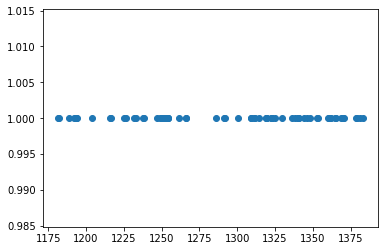

In [55]:
# plt.scatter(times_from_start, range(int(total_span)))
i = 10
j = 80
plt.scatter(times_from_start[i:j], np.ones(len(times_from_start))[i:j])